In [163]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Auto download data with COOL progession bar

In [149]:
import urllib
import os.path as path
import zipfile

length = 50
f_path = "./data/"
url = 'https://download.pytorch.org/tutorial/faces.zip'
fname = f_path + url.split('/')[-1]

if not path.exists(fname):  
    response = urllib.request.urlopen(url)
    meta = response.info()
    
    file_size = int(meta["Content-Length"])
    print("Downloading: %s Bytes: %s" % (file_name, file_size))
    file_size_dl = 0
    block_sz = 8192
    
    with open(file_name, "wb") as f:
        while True:
            buffer = response.read(block_sz)
            if not buffer:
                break

            file_size_dl += len(buffer)
            f.write(buffer)
            status = "\r%10d  [%3.2f%%]" % (file_size_dl, file_size_dl * 100. / file_size)
            ratio = file_size_dl / file_size
            status += "|" + "#" * int(ratio*length) + " " * int(length-ratio*length) + "|"
            sys.stdout.write(status)


with zipfile.ZipFile(fname, "r") as zfile:
    zfile.extractall(f_path)
    
    
def get_url_resource(url, root, fname=None):
    # TODO add function to make the download check file integrety / file existence
    fname = root + url.split('/')[-1] if fname==None else fname
    if path.exists(fname):
        return
    
    response = urllib.request.urlopen(url)
    meta = response.info()
    
    fsize = int(meta["Content-Length"])
    print("Downloading: %s Bytes: %s" % (fname, fsize))
    fsize_dl = 0
    bsize = 8192
    
    with open(fname, "wb") as f:
        while True:
            buffer = response.read(bsize)
            if not buffer:
                break

            fsize_dl += len(buffer)
            f.write(buffer)
            status = "\r%10d  [%3.2f%%]" % (fsize_dl, fsize_dl * 100. / fsize)
            ratio = fsize_dl / fsize
            status += "|" + "#" * int(ratio*length) + " " * int(length-ratio*length) + "|"
            sys.stdout.write(status)
  

Downloading: ./data/faces.zip Bytes: 5780252
   5780252  [100.00%]|##################################################|

# Pipelining data
### After 3 hours struggling loading the fukign file beautifully

In [78]:
# Load csv
landmarks_frame = pd.read_csv(data_path + "faces/face_landmarks.csv")

# Load a sample
img_name = face_landmarks.ix[68 , "image_name"]
landmark = face_landmarks.iloc[68, 1:].as_matrix().astype(float).reshape(-1, 2)

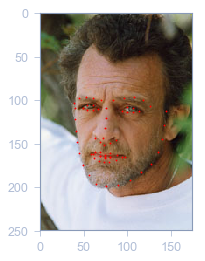

In [138]:
# Define iamge reading function
def show_landmarks(image, landmarks):
    # Plot the image
    plt.imshow(image)
    
    # Add the landmarks
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='#%02x%02x%02x' % (255, 0, 0), marker=".", s=10)
    
    # Something I don't know why it's here
    plt.pause(0.1)
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join(f_path, "faces", img_name)), landmark)


In [139]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return landmarks_frame.shape[0]
    
    def __getitem__(self, idx):
        # Path to image
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        # Image file
        image = io.imread(img_name)
        # parse landmark
        landmarks = landmarks_frame.iloc[idx, 1:].values.astype(float).reshape(-1, 2)
        
        sample = {"image": image, "landmarks": landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

0 (324, 215, 3) (68, 2)


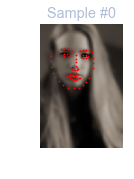

1 (500, 333, 3) (68, 2)


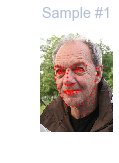

2 (250, 258, 3) (68, 2)


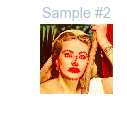

3 (434, 290, 3) (68, 2)


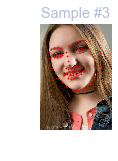

In [177]:
face_dataset = FaceLandmarksDataset(data_path + "faces/face_landmarks.csv", root_dir=data_path + "faces/")

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample["image"].shape, sample["landmarks"].shape)
    
    ax = plt.subplot(1, 4, i+1)
    
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis("off")
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

# Defining Classes for transformation

In [161]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

# Apply The transformation

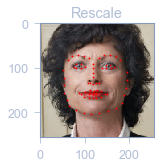

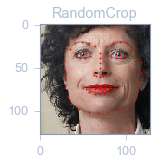

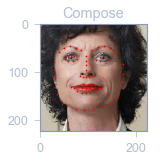

In [172]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)
                              ])

fig = plt.figure()
sample = face_dataset[65]

for i, trans in enumerate([scale, crop, composed]):
    transformed_sample = trans(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(trans).__name__)
    
    show_landmarks(**transformed_sample)
    
plt.show()

In [206]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


# Batching/Shuffling/parallel processing data

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
<class 'dict'>


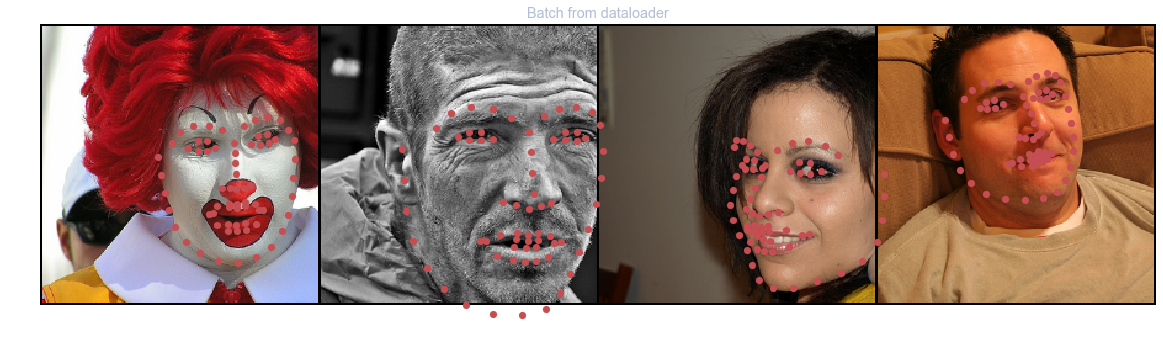

In [209]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

def show_landmarks_batch(sample_batched):
    print(type(sample_batched))
    images_batch, landmarks_batch = sample_batched["image"], sample_batched["landmarks"]
    
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1, 2, 0))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s = 200, marker=".", c="r")
        plt.title("Batch from dataloader")
        
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched["image"].size(),
          sample_batched["landmarks"].size())
    
    if i_batch == 3:
        plt.figure(figsize=[20, 50])
        show_landmarks_batch(sample_batched)
        plt.axis("off")
        plt.ioff()
        plt.show()
        break

# Torchvision

In [211]:
# import torch
# from torchvision import transforms, datasets

# data_transform = transforms.Compose([
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                              std=[0.229, 0.224, 0.225])
#     ])
# hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
#                                            transform=data_transform)
# dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
#                                              batch_size=4, shuffle=True,
#                                              num_workers=4)